In [1]:
git_repo = './../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

import LinearResponseVariationalBayes.ModelSensitivity as model_sens

# Local libraries
# import gmm_clustering_lib as gmm_utils
# import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

import autograd
from autograd import numpy as np
from autograd import scipy as sp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

np.random.seed(453453)

import json 

sys.path.append('./../../../paragami/')
import paragami

import gmm_clustering_lib as gmm_parag_lib
import modeling_lib

from numpy.polynomial.hermite import hermgauss

from scipy import optimize

In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Draw data

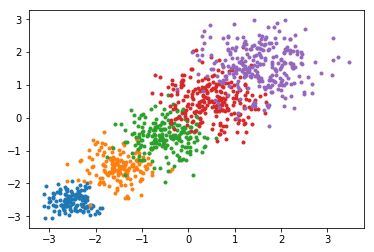

In [3]:
# load (or simulate) data
simulate = True
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    n_obs = len(iris_species)    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 5
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.6)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')
        
    iris_species = np.argmax(true_z, axis = 1)

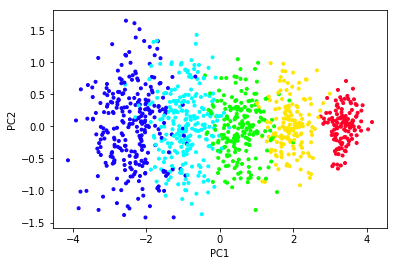

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


In [5]:
if simulate: 
    true_vb_params_dict = dict() 
    true_vb_params_dict['centroids'] = true_centroids.T
    true_vb_params_dict['v_stick_mean'] = np.ones(true_k - 1)
    true_vb_params_dict['v_stick_info'] = np.ones(true_k - 1)
    
    true_vb_params_dict['gamma'] = np.linalg.inv(true_covs)
    

# Set up model

### Get priors

In [6]:
prior_params_dict, prior_params_paragami = gmm_parag_lib.get_default_prior_params(dim)

In [7]:
print(prior_params_paragami)

OrderedDict:
	[alpha] = Array (1,) (lb=0.0, ub=inf)
	[prior_centroid_mean] = Array (1,) (lb=-inf, ub=inf)
	[prior_centroid_info] = Array (1,) (lb=0.0, ub=inf)
	[prior_gamma_df] = Array (1,) (lb=0.0, ub=inf)
	[prior_gamma_inv_scale] = PDMatrix 2x2 (diag_lb = 0.0)


In [8]:
# these are constrained parameters
print(prior_params_dict)

{'alpha': array([4.]), 'prior_centroid_mean': array([0.]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'prior_gamma_inv_scale': array([[0.62, 0.  ],
       [0.  , 0.62]])}


In [9]:
# these are free parameters
prior_params_paragami.flatten(prior_params_dict, free = True)

array([ 1.38629436,  0.        , -2.30258509,  2.07944154, -0.2390179 ,
        0.        , -0.2390179 ])

### the variational inference objective 

In [10]:
if simulate: 
    k_approx = true_k
else: 
    k_approx = 12

In [11]:
# Gauss-Hermite points
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [12]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_parag_lib.get_vb_params_paragami_object(dim, k_approx, n_obs)

In [13]:
gmm_parag_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

5689.9004767329925

# Optimization 

### run k-means init

In [14]:
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    gmm_parag_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init)

In [15]:
gmm_parag_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights)

2009.1366588247208

In [16]:
init_vb_params_dict

OrderedDict([('centroids',
              array([[ 1.62569551, -1.41775801,  0.61418475, -2.50371396, -0.38737027],
                     [ 1.69411384, -1.45047951,  0.65204004, -2.50292946, -0.42777756]])),
             ('v_stick_mean', array([1., 1., 1., 1.])),
             ('v_stick_info', array([1., 1., 1., 1.])),
             ('gamma', array([[[ 3.14337382,  0.76507563],
                      [ 0.76507563,  3.79340433]],
              
                     [[ 7.00664369,  0.65694837],
                      [ 0.65694837,  7.15775494]],
              
                     [[ 4.57635227,  1.82574309],
                      [ 1.82574309,  4.9507064 ]],
              
                     [[12.49900154,  0.05587787],
                      [ 0.05587787, 12.54026498]],
              
                     [[ 5.26937478,  0.50247437],
                      [ 0.50247437,  5.87118134]]]))])

In [17]:
init_vb_free_params

array([ 1.62569551e+00, -1.41775801e+00,  6.14184752e-01, -2.50371396e+00,
       -3.87370266e-01,  1.69411384e+00, -1.45047951e+00,  6.52040035e-01,
       -2.50292946e+00, -4.27777564e-01,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -1.00005000e-04, -1.00005000e-04,
       -1.00005000e-04, -1.00005000e-04,  5.72648344e-01,  4.31525388e-01,
        6.41464562e-01,  9.73429398e-01,  2.48185397e-01,  9.79776822e-01,
        7.60451117e-01,  8.53453653e-01,  7.20192756e-01,  1.26282438e+00,
        1.58052794e-02,  1.26446237e+00,  8.30955859e-01,  2.18894256e-01,
        8.80930691e-01])

In [18]:
def plot_results_from_vb_params_dict(vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


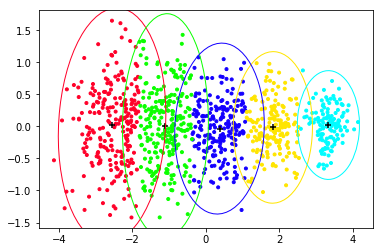

In [19]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(init_vb_params_dict, init_ez, fig)

### Set up losses

In [20]:
# Get loss as a function of the  vb_params_dict
get_vb_params_loss = paragami.Functor(original_fun=gmm_parag_lib.get_kl, argnums=1)
get_vb_params_loss.cache_args(features, None, prior_params_dict, gh_loc, gh_weights)

# Get loss as a function vb_free_params
get_vb_free_params_loss = paragami.FlattenedFunction(
                                            original_fun=get_vb_params_loss,
                                            patterns=vb_params_paragami,
                                            free=True)


In [21]:
# get gradient 
get_vb_free_params_loss_grad = autograd.grad(get_vb_free_params_loss)
get_vb_free_params_loss_hess = autograd.hessian(get_vb_free_params_loss)

In [25]:
bfgs_vb_free_pars, bfgs_output = \
    gmm_parag_lib.run_bfgs(get_vb_free_params_loss, init_vb_free_params, get_vb_free_params_loss_grad, 
                                 maxiter = 50)

         Current function value: 821.954341
         Iterations: 50
         Function evaluations: 59
         Gradient evaluations: 59


In [26]:
bfgs_vb_free_pars = bfgs_output.x
bfgs_vb_params_dict = vb_params_paragami.fold(bfgs_vb_free_pars, free=True)
bfgs_vb_params_dict

OrderedDict([('centroids',
              array([[ 1.06619845, -2.4813182 , -0.13639577, -1.44467254, -0.73683234],
                     [ 1.10051836, -2.48339064, -0.34725436, -1.47192297, -0.51160264]])),
             ('v_stick_mean',
              array([-0.09782577, -0.99769907, -0.53747353,  0.66364663])),
             ('v_stick_info',
              array([395.46319187, 321.54191957, 119.47519557,  54.19394248])),
             ('gamma', array([[[ 1.96409812, -0.77996422],
                      [-0.77996422,  1.98316918]],
              
                     [[ 9.50911213, -5.82956613],
                      [-5.82956613, 17.37541669]],
              
                     [[ 5.78469102, -1.69502617],
                      [-1.69502617,  2.77329766]],
              
                     [[ 7.24234905,  0.54820425],
                      [ 0.54820425,  9.28043283]],
              
                     [[ 8.12913157,  0.10790518],
                      [ 0.10790518, 12.72334081]]]))])

In [27]:
true_vb_params_dict

{'centroids': array([[-2.5, -1.5, -0.5,  0.5,  1.5],
        [-2.5, -1.5, -0.5,  0.5,  1.5]]),
 'gamma': array([[[13.88888889,  0.        ],
         [ 0.        , 13.88888889]],
 
        [[ 6.94444444,  0.        ],
         [ 0.        ,  6.94444444]],
 
        [[ 4.62962963,  0.        ],
         [ 0.        ,  4.62962963]],
 
        [[ 3.47222222,  0.        ],
         [ 0.        ,  3.47222222]],
 
        [[ 2.77777778,  0.        ],
         [ 0.        ,  2.77777778]]]),
 'v_stick_info': array([1., 1., 1., 1.]),
 'v_stick_mean': array([1., 1., 1., 1.])}

In [28]:
bfgs_ez = gmm_parag_lib.get_optimal_z_from_vb_params_dict(features, bfgs_vb_params_dict, gh_loc, gh_weights)

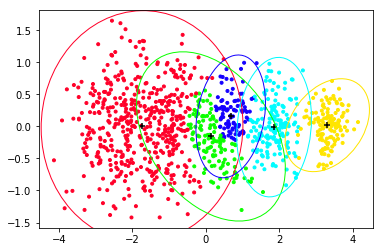

In [29]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(bfgs_vb_params_dict, bfgs_ez, fig)

### Get preconditioner and run Newton trust-region

In [32]:
trust_ncg_vb_free_pars, trust_ncg_output = \
    gmm_parag_lib.precondition_and_optimize(get_vb_free_params_loss, bfgs_output.x)

         Current function value: 821.365580
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 7
         Hessian evaluations: 6


In [33]:
vb_opt_dict = \
    vb_params_paragami.fold(trust_ncg_vb_free_pars, free = True)
    
vb_opt_dict

OrderedDict([('centroids',
              array([[ 1.00351216, -2.4824071 , -0.10851113, -1.43453789, -0.76353568],
                     [ 1.04315865, -2.4840903 , -0.43192867, -1.46906232, -0.50280569]])),
             ('v_stick_mean',
              array([ 0.02606562, -0.92115485, -0.89441802,  0.59883537])),
             ('v_stick_info',
              array([395.27757887, 319.99630288, 117.25677726,  54.79361557])),
             ('gamma', array([[[ 1.91776922, -0.85140056],
                      [-0.85140056,  1.96167036]],
              
                     [[ 9.55602261, -5.81768155],
                      [-5.81768155, 17.38185405]],
              
                     [[ 8.883883  , -2.02397797],
                      [-2.02397797,  3.10315759]],
              
                     [[ 7.11113228,  0.45238749],
                      [ 0.45238749,  8.96388679]],
              
                     [[ 9.36546834, -0.03507356],
                      [-0.03507356, 11.51461556]]]))])

In [34]:
opt_ez = gmm_parag_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

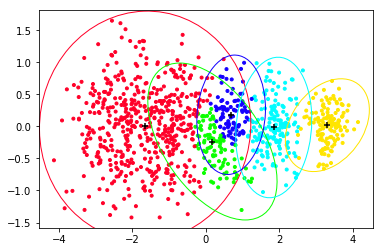

In [35]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(vb_opt_dict, opt_ez, fig)

# Checking out optimize full

In [36]:
vb_opt = gmm_parag_lib.optimize_full(features, vb_params_paragami, prior_params_dict,
                    init_vb_free_params, gh_loc, gh_weights,
                    bfgs_max_iter = 10, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: 951.373378
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14

 running preconditioned newton; iter =  0
         Current function value: 915.654926
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 44
         Hessian evaluations: 43
Iter 0: x_diff = 14.068472616591102, f_diff = 35.71845143043254, grad_l1 = 284.7877931804222

 running preconditioned newton; iter =  1
         Current function value: 869.030383
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 41
         Hessian evaluations: 40
Iter 1: x_diff = 9.862464225339895, f_diff = 46.62454299099261, grad_l1 = 366.18188610995753

 running preconditioned newton; iter =  2
         Current function value: 785.422803
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 46
         Hessian evaluations: 45
Iter 2: x_diff = 22.5050

In [37]:
vb_opt_dict = \
    vb_params_paragami.fold(vb_opt, free = True)
    
vb_opt_dict

OrderedDict([('centroids',
              array([[ 1.44518137, -1.48826226,  0.52792757, -2.51090444, -0.43212443],
                     [ 1.55005946, -1.49917321,  0.52514419, -2.52419779, -0.500029  ]])),
             ('v_stick_mean',
              array([-0.89258493, -1.24381947, -0.70229932, -0.60371342])),
             ('v_stick_info',
              array([207.05401274, 123.95722631, 122.7389125 ,  84.78483305])),
             ('gamma', array([[[ 2.33552063, -0.10093305],
                      [-0.10093305,  2.90521733]],
              
                     [[ 7.0679223 ,  0.53229187],
                      [ 0.53229187,  7.32144721]],
              
                     [[ 3.98888188,  1.70979412],
                      [ 1.70979412,  6.16960073]],
              
                     [[12.44733962,  0.64232963],
                      [ 0.64232963, 14.85653959]],
              
                     [[ 4.11368802, -0.80290168],
                      [-0.80290168,  4.8131438 ]]]))])

In [38]:
opt_ez = gmm_parag_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

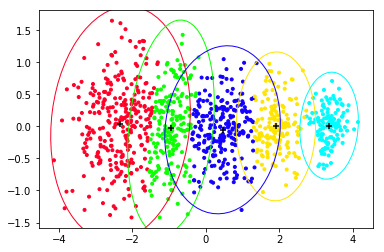

In [39]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(vb_opt_dict, opt_ez, fig)